# Explore Predictions

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

import altair as alt
from altair import *

import plotly.express as px
import plotly.graph_objects as go

## Load Data

Modify data name  
Modify timesteps

In [2]:
####
# MODIFY the time steps as you see fit, you may want to look at the number of points in a day, and choose that 
# Or choose any other time period 
####

TIMESTEP_LIST = [15,30,45]

In [3]:
THRESHOLD_LIST = [0.33,0.5,0.75] # THESE ARE PERCENTAGES OF THE MAX MAE, A LOWER PERCENTAGE WILL FIND MORE ANOMALIES

In [4]:
data_dir = "./"
data_set_1_name = "CEC_compiled_data_1a_updated.csv"
data_set_2_name = "CEC_compiled_data_1b_updated.csv"

In [5]:
data_without_labels = pd.read_csv(data_dir + data_set_1_name)
data_without_labels = data_without_labels.rename(columns={'Anomaly': 'anomaly_by_human'})
data_without_labels.head()

,Datetime,Value,ID,anomaly_by_human
0,2020-01-01 07:58:52,9.6,Campus Energy Centre Campus HW Main Meter Power,False
1,2020-01-01 08:00:00,9.6,Campus Energy Centre Campus HW Main Meter Power,False
2,2020-01-01 08:01:34,10.3,Campus Energy Centre Campus HW Main Meter Power,False
3,2020-01-01 08:04:15,11.0,Campus Energy Centre Campus HW Main Meter Power,False
4,2020-01-01 08:07:36,10.3,Campus Energy Centre Campus HW Main Meter Power,False


In [6]:
data_with_labels = pd.read_csv(data_dir + data_set_2_name)
data_with_labels = data_with_labels.rename(columns={'Anomaly': 'anomaly_by_human'})
data_with_labels["anomaly_by_human"] = data_with_labels["anomaly_by_human"].apply(lambda x: str(x))
data_with_labels.head()

,Datetime,Value,ID,anomaly_by_human
0,2020-01-01 07:58:52,9.6,Campus Energy Centre Campus HW Main Meter Power,False
1,2020-01-01 08:00:00,9.6,Campus Energy Centre Campus HW Main Meter Power,False
2,2020-01-01 08:01:34,10.3,Campus Energy Centre Campus HW Main Meter Power,False
3,2020-01-01 08:04:15,11.0,Campus Energy Centre Campus HW Main Meter Power,False
4,2020-01-01 08:07:36,10.3,Campus Energy Centre Campus HW Main Meter Power,False


Some datasets have 3 versions (i.e seasonal anomalies not counted)  
Another `pd.read_csv()` call will need to be done here

# Split data into 80-20 train test split

In [7]:
train_split_number = int(len(data_with_labels) * .8)
train = data_with_labels.head(train_split_number)
test = data_with_labels.tail(len(data_with_labels) - train_split_number)

# Create sequences of time steps

In [8]:
train["raw_value"] = train["Value"]
test["raw_value"] = test["Value"]

test_raw = test["Value"].copy(deep=True)

scaler = StandardScaler()
scaler = scaler.fit(train[['Value']])

train['Value'] = scaler.transform(train[['Value']])
test['Value'] = scaler.transform(test[['Value']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [9]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [10]:
data_dict = {}

for timestep in TIMESTEP_LIST:
    X_train, y_train = create_sequences(train[['Value']], train['Value'], time_steps=timestep)
    X_test, y_test = create_sequences(test[['Value']], test['Value'], time_steps=timestep)
    data_timestepped = {}
    data_timestepped["x_train"] = X_train
    data_timestepped["y_train"] = y_train
    data_timestepped["x_test"] = X_test
    data_timestepped["y_test"] = y_test
    data_dict[timestep] = data_timestepped


In [11]:
for ts in data_dict.keys():
    print("time step size", ts)
    for _, data_set in data_dict[ts].items():
      print(data_set.shape)
    print("\n")

time step size 15
(303861, 15, 1)
(303861,)
(75955, 15, 1)
(75955,)


time step size 30
(303846, 30, 1)
(303846,)
(75940, 30, 1)
(75940,)


time step size 45
(303831, 45, 1)
(303831,)
(75925, 45, 1)
(75925,)




In [12]:
test.head()

,Datetime,Value,ID,anomaly_by_human,raw_value
303876,2021-01-31 22:43:03,1.044095,Campus Energy Centre Campus HW Main Meter Power,False,21.600000
303877,2021-01-31 22:44:24,0.868113,Campus Energy Centre Campus HW Main Meter Power,False,20.100000
303878,2021-01-31 22:47:56,0.633469,Campus Energy Centre Campus HW Main Meter Power,False,18.100000
303879,2021-01-31 22:48:56,0.926773,Campus Energy Centre Campus HW Main Meter Power,False,20.600000
303880,2021-01-31 22:50:00,0.891577,Campus Energy Centre Campus HW Main Meter Power,False,20.300001


# Step up model

In [13]:
def create_model(x_input):
  model = Sequential()
  model.add(LSTM(128, input_shape=(x_input.shape[1], x_input.shape[2])))
  model.add(Dropout(rate=0.2))
  model.add(RepeatVector(x_input.shape[1]))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(Dense(x_input.shape[2])))
  model.compile(optimizer='adam', loss='mae')
  model.summary()
  return model

# Train a Model for Each timestep

In [14]:
for key, inner_data in data_dict.items():
    x_train = inner_data["x_train"]
    y_train = inner_data["y_train"]
    print(x_train.shape)
    print(y_train.shape)
    model = create_model(x_train)
    history = model.fit(x_train, y_train, epochs=100, batch_size=32*4, validation_split=0.1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)
    inner_data["history"] = history
    inner_data["model"] = model
    model = None

(303861, 15, 1)
(303861,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________

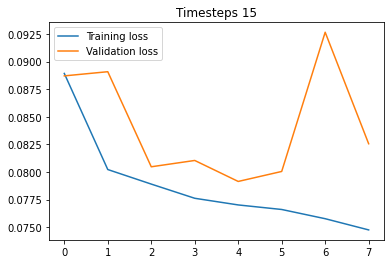

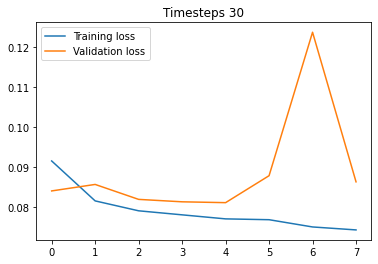

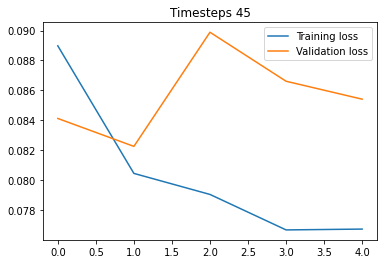

In [15]:
for ts in data_dict.keys():
  history = data_dict[ts]["history"]
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title("Timesteps {}".format(ts))
  plt.legend();
  plt.show()

In [16]:
for ts in data_dict.keys():
  print("evaluating for timestep: {}".format(ts))
  x_test = data_dict[ts]["x_test"]
  y_test = data_dict[ts]["y_test"]
  model = data_dict[ts]["model"]
  print(model.evaluate(x_test, y_test))

evaluating for timestep: 15
2374/2374 [==============================] - 7s 3ms/step - loss: 0.0991
0.0991474986076355
evaluating for timestep: 30
2374/2374 [==============================] - 8s 3ms/step - loss: 0.1004
0.10039545595645905
evaluating for timestep: 45
2373/2373 [==============================] - 9s 4ms/step - loss: 0.1001
0.10014548152685165


In [17]:
for ts in data_dict.keys():
  print("computing info for {}".format(ts))
  model = data_dict[ts]["model"]
  x_train = data_dict[ts]["x_train"]
  y_train = data_dict[ts]["y_train"]
  x_test = data_dict[ts]["x_test"]
  y_test = data_dict[ts]["y_test"]


  x_train_pred = model.predict(x_train, verbose=0)
  train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
  train_score_df = pd.DataFrame(train[ts:])
  train_score_df['loss'] = train_mae_loss
  train_score_df['Value'] = train[ts:]['Value']
  data_dict[ts]["train_score_df"] = train_score_df

  x_test_pred = model.predict(x_test, verbose=0)
  test_mae_loss = np.mean(np.abs(x_test_pred-x_test), axis=1)
  test_score_df = pd.DataFrame(test[ts:])
  test_score_df['loss'] = test_mae_loss
  test_score_df['Value'] = test[ts:]['Value']
  data_dict[ts]["test_score_df"] = test_score_df

computing info for 15
computing info for 30
computing info for 45


Calculates anomalies based on different thresholds, If you want to try different values change `THRESHOLD_LIST` at the top of the notebook, or define it again here with new values

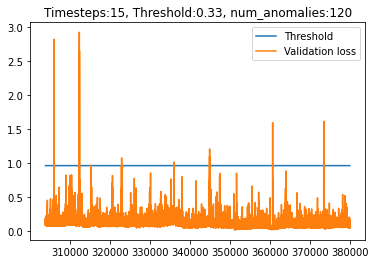

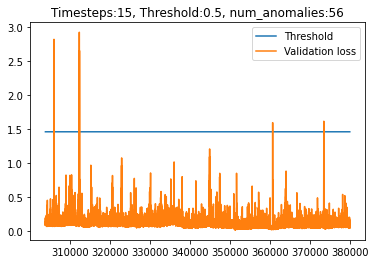

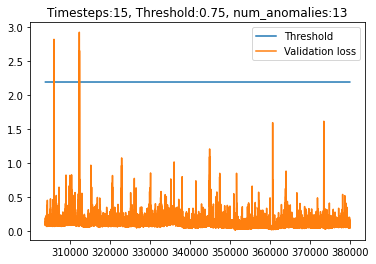

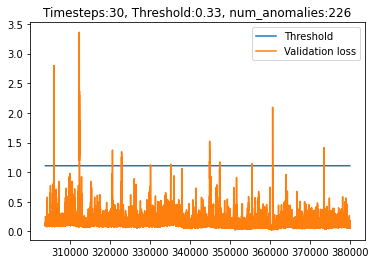

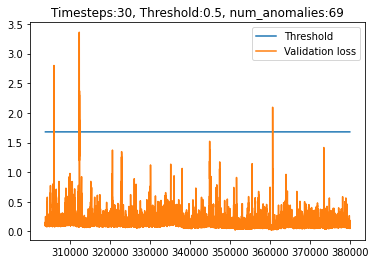

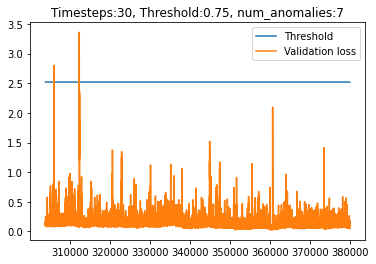

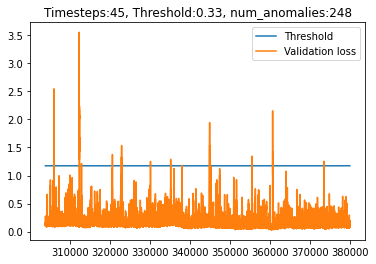

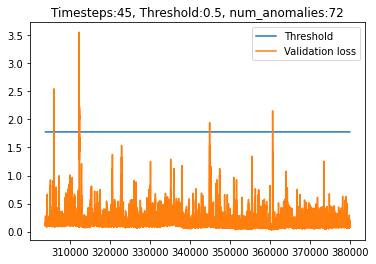

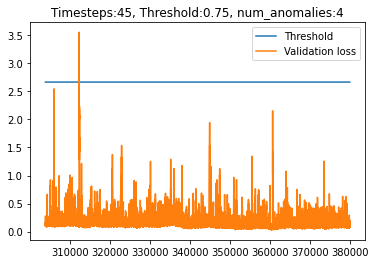

In [18]:
for ts in data_dict.keys():
  for thresh in THRESHOLD_LIST:

    test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
    max_error = test_score_df["loss"].max()
    threshold = max_error * thresh
    
    test_score_df['threshold'] = threshold
    test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']

    anomalies = test_score_df.loc[test_score_df['anomaly_by_machine'] == True]
    num_anomalies = anomalies.shape[0]

    plt.plot(test_score_df['threshold'], label='Threshold')
    plt.plot(test_score_df['loss'], label='Validation loss')
    plt.title("Timesteps:{}, Threshold:{}, num_anomalies:{}".format(ts, thresh, num_anomalies))
    plt.legend();
    plt.show()

In [28]:
# for ts in data_dict.keys():
#   for thresh in THRESHOLD_LIST[0:2]:

#     test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
#     max_error = test_score_df["loss"].max()
#     threshold = max_error * thresh
    
#     test_score_df['threshold'] = threshold
#     test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
#     test_score_df["raw_value"] = test_raw[ts:]
#     test_score_df["anomaly_by_machine_int"] = test_score_df['anomaly_by_machine'].apply(lambda x: str(x))

#     test_score_df["year_month"] = test_score_df["Datetime"].apply(lambda x: "-".join(x.split("-")[0:2]))

    
#     fig = px.scatter(test_score_df, x="Datetime", y="raw_value", color="anomaly_by_machine_int", 
#                      title="Anomalies Detected for Timestep:{}, Threshold:{}".format(ts, thresh))
    
#     human_anomalies = test[test["anomaly_by_human"] == "True"]
    
#     fig.add_trace(go.Scatter(x=human_anomalies["Datetime"], y=human_anomalies["raw_value"], mode="markers",
#                 marker=dict(size=10, color="Black"),
#                 name="anomaly_by_human=True"))

#     fig.show()


In [29]:
# for thresh in THRESHOLD_LIST:
#   for ts in data_dict.keys():

#     test_score_df = data_dict[ts]["test_score_df"].copy(deep=True)
#     max_error = test_score_df["loss"].max()
#     threshold = max_error * thresh
    
#     test_score_df['threshold'] = threshold
#     test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
#     test_score_df["raw_value"] = test_raw[ts:]
#     test_score_df["anomaly_by_machine_int"] = test_score_df['anomaly_by_machine'].apply(lambda x: str(x))

#     test_score_df["year_month"] = test_score_df["Datetime"].apply(lambda x: "-".join(x.split("-")[0:2]))

    
#     fig = px.scatter(test_score_df, x="Datetime", y="raw_value", color="anomaly_by_machine_int", 
#                      title="Anomalies Detected for Timestep:{}, Threshold:{}".format(ts, thresh))
    
#     human_anomalies = test[test["anomaly_by_human"] == "True"]
    
#     fig.add_trace(go.Scatter(x=human_anomalies["Datetime"], y=human_anomalies["raw_value"], mode="markers",
#                 marker=dict(size=10, color="Black"),
#                 name="anomaly_by_human=True"))

#     fig.show()